## Exploration on which heuristics affected the correlation and to what extent.

### Initialization

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pickle
from sklearn.metrics import jaccard_score
import itertools
from scipy import stats

In [2]:
MODULE_PATH = Path(os.getcwd()).parents[2].resolve()

sweep_path = "filtering_heuristic_sweeps.csv"

path_combined = 'combined_dataset.csv'
path_sts = 'sts.csv'
path_qqp = 'qqp.csv'
path_sample_qqp = 'sample_qqp.csv'

PATH_DATA = MODULE_PATH / 'data'
PATH_COMBINED = PATH_DATA / 'datasets' / path_combined
PATH_STS = PATH_DATA / 'datasets' / path_sts
PATH_SAMPLE_QQP = PATH_DATA / 'datasets' / path_sample_qqp
PATH_REPORTS = PATH_DATA / 'reports'

In [23]:
combined_path = "combined_ba.pickle"

with open(MODULE_PATH / 'data' / 'bad_annotators' / combined_path, 'rb') as f:
    combined_ba = pickle.load(f)
df_combined = pd.read_csv(PATH_COMBINED, index_col=0)

In [28]:
df_sweep = pd.read_csv(PATH_REPORTS / sweep_path)

#We only want to look at the combined dataset for this example
df_sweep.test_dataset.fillna("combined_dataset",inplace=True)
df_sweep = df_sweep[df_sweep.test_dataset == "combined_dataset"]

# PREPROCCESING

In [30]:
#number of heuristics used
df_sweep['num_heuristics'] = df_sweep.bad_annotators.apply(lambda x: len(eval(x)))
# Improvement of correlation using filtering method
df_sweep['RF_Increase'] = df_sweep["RF PearsonR"] - df_sweep["Base Top Correlation"]
# Percent on improvement
df_sweep['RF_Percent_Increase'] = np.round((df_sweep['RF_Increase'] / df_sweep["Base Top Correlation"])*100,2)
df_sweep['metric_len'] = df_sweep["metrics"].apply(lambda x: len(eval(x)))

In [31]:
all_heurstics = [eval(c) for c in df_sweep.bad_annotators.unique()]

In [32]:
sweep_dict = dict() # For each group of heuristics, have the number of annotators included and the amount of the data removed
total_rows = df_combined.shape[0]
for key_pair in all_heurstics:
    ba = []
    for key in key_pair:
        ba += combined_ba[key]
    ba = list(set(ba))
    sweep_dict[str(key_pair)] = dict()
    sweep_dict[str(key_pair)]['num annotators'] = len(ba)
    sweep_dict[str(key_pair)]['percentage of data filtered'] = np.round((df_combined[df_combined.annotator.isin(ba)].shape[0] / total_rows)*100,2)

In [33]:
df_sweep["num_filtered_annotators"] = df_sweep.bad_annotators.apply(lambda x: sweep_dict[str(eval(x))]['num annotators'])
df_sweep["percentage_data_filtered"] = df_sweep.bad_annotators.apply(lambda x: sweep_dict[str(eval(x))]['percentage of data filtered'])

# EVALUATION

### Distribution of the Increases within the hyper-parameter sweep

In [40]:
df = df_sweep.copy()

       RF_Increase  RF_Percent_Increase
count   252.000000           252.000000
mean      0.031786             7.661032
std       0.002588             0.713370
min       0.027670             6.560000
25%       0.030267             7.180000
50%       0.031434             7.570000
75%       0.033105             8.095000
max       0.036572             8.940000


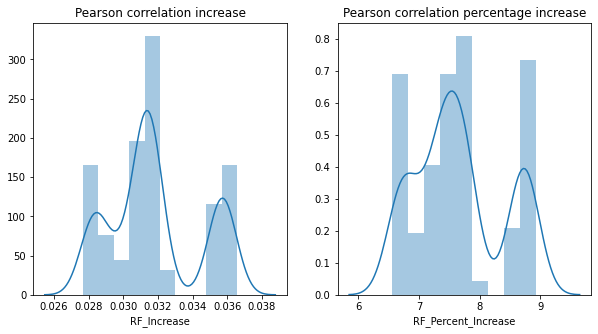

In [41]:
f, ax = plt.subplots(1,2,figsize = (10,5))
ax = plt.subplot(1,2,1)
sns.distplot(df.RF_Increase, ax = ax);
ax = plt.title('Pearson correlation increase')

ax = plt.subplot(1,2,2)
sns.distplot(df.RF_Percent_Increase, ax = ax );
ax = plt.title('Pearson correlation percentage increase')

print(df[['RF_Increase','RF_Percent_Increase']].describe())

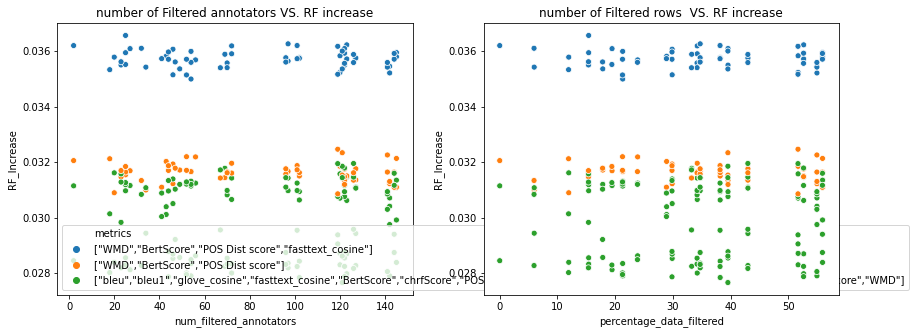

In [42]:
f, ax = plt.subplots(1,2,figsize = (14,5))
ax = plt.subplot(1,2,1)
sns.scatterplot('num_filtered_annotators', 'RF_Increase',hue = 'metrics', data = df)
ax = plt.title('number of Filtered annotators VS. RF increase')


ax = plt.subplot(1,2,2)
sns.scatterplot('percentage_data_filtered', 'RF_Increase',hue = 'metrics', data = df,  legend = False)
ax = plt.title('number of Filtered rows  VS. RF increase')

We see that the main impact on the RF Increase has to do with metrics we take for the RF.

What if we looked at just the impact of each heuristic individually:

In [44]:
df[df.num_heuristics == 1].groupby(["metric_len","bad_annotators"])['RF_Increase'].agg(['mean','max','std'])

mean       max       std
metric_len bad_annotators                                          
3          ["duration"]                0.031346  0.031346       NaN
           ["high_random"]             0.031703  0.031703       NaN
           ["low_std"]                 0.031768  0.031768       NaN
           ["random_honeypot"]         0.032130  0.032130       NaN
           ["sentiment_inconsistent"]  0.031852  0.031852       NaN
           ["unpopular"]               0.032064  0.032064       NaN
4          ["duration"]                0.036110  0.036110       NaN
           ["high_random"]             0.035625  0.035625       NaN
           ["low_std"]                 0.035613  0.035613       NaN
           ["random_honeypot"]         0.035339  0.035339       NaN
           ["sentiment_inconsistent"]  0.035526  0.035526       NaN
           ["unpopular"]               0.036207  0.036207       NaN
13         ["duration"]                0.029564  0.030847  0.001813
           ["high_random"]             0.029745  0.031290  0.002185
           ["low_std"]                 0.030100  0.031448  0.001906
           ["random_honeypot"]         0.029088  0.030146  0.001497
           ["sentiment_inconsistent"]  0.029785  0.031270  0.002100
           ["unpopular"]               0.029805  0.031154  0.001907

## Conclusion: In order to really see the impact of the filtered heuristics, we have to not use the RF but just take the pearson correlation before and after filtering.

# ESTABLISH BASELINE CORRELATION INCREASE

In [46]:
METRICS = ['bleu', 
           'bleu1',
           'glove_cosine',
           'fasttext_cosine',
           'BertScore',
           'chrfScore',
           'POS Dist score',
           '1-gram_overlap',
           'ROUGE-1',
           'ROUGE-2',
           'ROUGE-l',
           'L2_score',
           'WMD']

In [47]:
mean_label = df_combined.groupby("pair_id")['label'].mean()
metric_columns = df_combined.groupby("pair_id")[METRICS].mean()
metric_columns["label"] = mean_label
baseline_metrics = metric_columns.corr().abs().iloc[-1].sort_values(ascending=False)[1:]

In [48]:
df_correlation = pd.DataFrame(baseline_metrics)
df_correlation

,label
ROUGE-1,0.609100
bleu1,0.602646
ROUGE-l,0.601263
BertScore,0.592847
1-gram_overlap,0.589430
chrfScore,0.583801
L2_score,0.562731
ROUGE-2,0.531277
fasttext_cosine,0.509271
WMD,0.498807


In [49]:
df_correlation = pd.DataFrame(baseline_metrics)
for keys in all_heurstics:
    ba = []
    for key in keys:
        ba += combined_ba[key]
    ba = list(set(ba))
    df_ba = df_combined[~df_combined.annotator.isin(ba)]
    mean_label = df_ba.groupby("pair_id")['label'].mean()
    metric_columns = df_ba.groupby("pair_id")[METRICS].mean()
    metric_columns["label"] = mean_label
    filtered_correlation = metric_columns.corr().abs().iloc[-1].sort_values(ascending=False)[1:] - df_correlation.iloc[:,0]
    filtered_correlation.name = str(keys)
    df_correlation = pd.concat((df_correlation, filtered_correlation),axis=1)

In [50]:
df_correlation

,label,"['duration', 'random_honeypot', 'low_std', 'high_random', 'unpopular', 'sentiment_inconsistent']","['random_honeypot', 'low_std', 'high_random', 'unpopular', 'sentiment_inconsistent']","['duration', 'low_std', 'high_random', 'unpopular', 'sentiment_inconsistent']","['duration', 'random_honeypot', 'high_random', 'unpopular', 'sentiment_inconsistent']","['duration', 'random_honeypot', 'low_std', 'unpopular', 'sentiment_inconsistent']","['duration', 'random_honeypot', 'low_std', 'high_random', 'sentiment_inconsistent']","['duration', 'random_honeypot', 'low_std', 'high_random', 'unpopular']","['low_std', 'high_random', 'unpopular', 'sentiment_inconsistent']","['random_honeypot', 'high_random', 'unpopular', 'sentiment_inconsistent']",...,"['duration', 'unpopular']","['duration', 'high_random']","['duration', 'low_std']","['duration', 'random_honeypot']",['sentiment_inconsistent'],['unpopular'],['high_random'],['low_std'],['random_honeypot'],['duration']
ROUGE-1,0.609100,0.046149,0.045974,0.046149,-0.038130,0.031988,0.045984,0.059027,0.045974,-0.028618,...,-0.021282,0.007148,0.035781,-0.002359,-0.060734,0.000063,0.024650,0.045955,0.015772,-0.021359
bleu1,0.602646,0.047491,0.047128,0.047491,-0.035704,0.033579,0.047334,0.058248,0.047128,-0.026221,...,-0.021236,0.007465,0.035015,-0.002189,-0.058902,0.000054,0.024857,0.045005,0.016025,-0.021304
ROUGE-l,0.601263,0.047814,0.047572,0.047814,-0.035193,0.034220,0.047673,0.057460,0.047572,-0.025616,...,-0.021297,0.006717,0.034992,-0.002317,-0.057588,0.000062,0.024341,0.045223,0.016024,-0.021372
BertScore,0.592847,0.050366,0.048774,0.050366,-0.033982,0.037187,0.050121,0.059130,0.048774,-0.024875,...,-0.020413,0.007190,0.035643,-0.002889,-0.055527,0.000062,0.024256,0.044831,0.014993,-0.020488
1-gram_overlap,0.589430,0.046893,0.047123,0.046893,-0.035926,0.033525,0.046748,0.056380,0.047123,-0.025792,...,-0.021695,0.005646,0.033941,-0.003319,-0.056978,0.000030,0.023639,0.044740,0.015483,-0.021740
chrfScore,0.583801,0.042450,0.043070,0.042450,-0.035973,0.030100,0.042332,0.053269,0.043070,-0.026204,...,-0.020743,0.005432,0.031420,-0.003427,-0.055161,0.000025,0.022406,0.042084,0.014387,-0.020782
L2_score,0.562731,0.037163,0.037011,0.037163,-0.032999,0.023165,0.036842,0.052402,0.037011,-0.025160,...,-0.018054,0.008814,0.030534,-0.000272,-0.055312,0.000169,0.023764,0.039202,0.015323,-0.018233
ROUGE-2,0.531277,0.044601,0.045474,0.044601,-0.030308,0.032675,0.044545,0.048289,0.045474,-0.019420,...,-0.020528,0.003470,0.027833,-0.004310,-0.047021,0.000014,0.020790,0.038512,0.014029,-0.020555
fasttext_cosine,0.509271,0.011021,0.013091,0.011021,-0.040536,-0.001889,0.010707,0.033253,0.013091,-0.032567,...,-0.016148,0.001553,0.014775,-0.005746,-0.054894,0.000228,0.015506,0.023362,0.008378,-0.016384
WMD,0.498807,0.022178,0.023736,0.022178,-0.034200,0.011259,0.022234,0.042727,0.023736,-0.026985,...,-0.016041,0.006972,0.023530,-0.001033,-0.053168,-0.000095,0.020187,0.032394,0.012377,-0.015959


Above shows how much the correlation increased (or decreased) for each metric based off the heuristics and all the combinations.

In [51]:
#Exploring single heuristics
single_heuristics = [f"['{str(x)}']" for x in list(combined_ba.keys())[:-1]]
df_correlation[single_heuristics]

,['duration'],['random_honeypot'],['low_std'],['high_random'],['unpopular'],['sentiment_inconsistent']
ROUGE-1,-0.021359,0.015772,0.045955,0.024650,0.000063,-0.060734
bleu1,-0.021304,0.016025,0.045005,0.024857,0.000054,-0.058902
ROUGE-l,-0.021372,0.016024,0.045223,0.024341,0.000062,-0.057588
BertScore,-0.020488,0.014993,0.044831,0.024256,0.000062,-0.055527
1-gram_overlap,-0.021740,0.015483,0.044740,0.023639,0.000030,-0.056978
chrfScore,-0.020782,0.014387,0.042084,0.022406,0.000025,-0.055161
L2_score,-0.018233,0.015323,0.039202,0.023764,0.000169,-0.055312
ROUGE-2,-0.020555,0.014029,0.038512,0.020790,0.000014,-0.047021
fasttext_cosine,-0.016384,0.008378,0.023362,0.015506,0.000228,-0.054894
WMD,-0.015959,0.012377,0.032394,0.020187,-0.000095,-0.053168


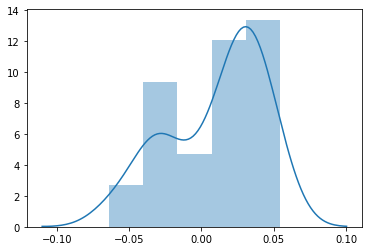

In [54]:
#Distribution of the mean improvement using the heuristics 

sns.distplot(df_correlation.iloc[:,1:].mean());

# Exploration as to which heuristics as responsible for the increase in correlation

In [55]:
df_correlation = df_correlation.T.reset_index()

In [56]:
df_correlation = df_correlation.rename(columns={"index":"heur_used"})

In [58]:
# Add a one-hot encoding is the heuristics used included the given heuristic

for huer in list(combined_ba.keys())[:-1]:
    df_correlation[f"has_{huer}"] = df_correlation.heur_used.apply(lambda x: huer in x).astype(int)
df_correlation

,heur_used,ROUGE-1,bleu1,ROUGE-l,BertScore,1-gram_overlap,chrfScore,L2_score,ROUGE-2,fasttext_cosine,WMD,glove_cosine,bleu,POS Dist score,has_duration,has_random_honeypot,has_low_std,has_high_random,has_unpopular,has_sentiment_inconsistent
0,label,0.609100,0.602646,0.601263,0.592847,0.589430,0.583801,0.562731,0.531277,0.509271,0.498807,0.453841,0.411319,0.351291,0,0,0,0,0,0
1,"['duration', 'random_honeypot', 'low_std', 'hi...",0.046149,0.047491,0.047814,0.050366,0.046893,0.042450,0.037163,0.044601,0.011021,0.022178,0.020794,0.037181,0.025121,1,1,1,1,1,1
2,"['random_honeypot', 'low_std', 'high_random', ...",0.045974,0.047128,0.047572,0.048774,0.047123,0.043070,0.037011,0.045474,0.013091,0.023736,0.020214,0.038328,0.025942,0,1,1,1,1,1
3,"['duration', 'low_std', 'high_random', 'unpopu...",0.046149,0.047491,0.047814,0.050366,0.046893,0.042450,0.037163,0.044601,0.011021,0.022178,0.020794,0.037181,0.025121,1,0,1,1,1,1
4,"['duration', 'random_honeypot', 'high_random',...",-0.038130,-0.035704,-0.035193,-0.033982,-0.035926,-0.035973,-0.032999,-0.030308,-0.040536,-0.034200,-0.032470,-0.021516,-0.031616,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,['unpopular'],0.000063,0.000054,0.000062,0.000062,0.000030,0.000025,0.000169,0.000014,0.000228,-0.000095,0.000160,0.000038,-0.000190,0,0,0,0,1,0
60,['high_random'],0.024650,0.024857,0.024341,0.024256,0.023639,0.022406,0.023764,0.020790,0.015506,0.020187,0.015627,0.016826,0.013639,0,0,0,1,0,0
61,['low_std'],0.045955,0.045005,0.045223,0.044831,0.044740,0.042084,0.039202,0.038512,0.023362,0.032394,0.024603,0.030077,0.029335,0,0,1,0,0,0
62,['random_honeypot'],0.015772,0.016025,0.016024,0.014993,0.015483,0.014387,0.015323,0.014029,0.008378,0.012377,0.008732,0.011781,0.008408,0,1,0,0,0,0


In [59]:
df_correlation.columns

Index(['heur_used', 'ROUGE-1', 'bleu1', 'ROUGE-l', 'BertScore',
       '1-gram_overlap', 'chrfScore', 'L2_score', 'ROUGE-2', 'fasttext_cosine',
       'WMD', 'glove_cosine', 'bleu', 'POS Dist score', 'has_duration',
       'has_random_honeypot', 'has_low_std', 'has_high_random',
       'has_unpopular', 'has_sentiment_inconsistent'],
      dtype='object')

In [60]:
df_correlation.groupby("has_sentiment_inconsistent").mean()

,ROUGE-1,bleu1,ROUGE-l,BertScore,1-gram_overlap,chrfScore,L2_score,ROUGE-2,fasttext_cosine,WMD,glove_cosine,bleu,POS Dist score,has_duration,has_random_honeypot,has_low_std,has_high_random,has_unpopular
has_sentiment_inconsistent,,,,,,,,,,,,,,,,,,
0,0.048329,0.047771,0.047431,0.047503,0.046325,0.044518,0.043966,0.040202,0.031078,0.037144,0.030989,0.030690,0.027243,0.5,0.5,0.5,0.5,0.5
1,-0.002258,-0.000404,0.000256,0.001979,-0.000132,-0.001792,-0.004320,0.002870,-0.019317,-0.010566,-0.011050,0.004954,-0.004737,0.5,0.5,0.5,0.5,0.5


In [61]:
df_correlation.groupby("has_high_random").mean()

,ROUGE-1,bleu1,ROUGE-l,BertScore,1-gram_overlap,chrfScore,L2_score,ROUGE-2,fasttext_cosine,WMD,glove_cosine,bleu,POS Dist score,has_duration,has_random_honeypot,has_low_std,has_unpopular,has_sentiment_inconsistent
has_high_random,,,,,,,,,,,,,,,,,,
0,0.023386,0.023936,0.024326,0.025085,0.023534,0.022148,0.019904,0.022066,0.006761,0.013598,0.010397,0.018060,0.012100,0.5,0.5,0.5,0.5,0.5
1,0.022685,0.023431,0.023361,0.024397,0.022659,0.020578,0.019742,0.021006,0.005000,0.012980,0.009542,0.017583,0.010406,0.5,0.5,0.5,0.5,0.5


In [62]:
df_correlation.groupby("has_low_std").mean()

,ROUGE-1,bleu1,ROUGE-l,BertScore,1-gram_overlap,chrfScore,L2_score,ROUGE-2,fasttext_cosine,WMD,glove_cosine,bleu,POS Dist score,has_duration,has_random_honeypot,has_high_random,has_unpopular,has_sentiment_inconsistent
has_low_std,,,,,,,,,,,,,,,,,,
0,0.000634,0.001694,0.001865,0.002324,0.001049,0.000898,0.002030,0.002125,-0.004923,-0.000756,-0.002128,0.002548,-0.003779,0.5,0.5,0.5,0.5,0.5
1,0.045438,0.045673,0.045822,0.047158,0.045145,0.041828,0.037616,0.040947,0.016683,0.027334,0.022067,0.033096,0.026285,0.5,0.5,0.5,0.5,0.5


In [63]:
df_correlation.groupby("has_random_honeypot").mean()

,ROUGE-1,bleu1,ROUGE-l,BertScore,1-gram_overlap,chrfScore,L2_score,ROUGE-2,fasttext_cosine,WMD,glove_cosine,bleu,POS Dist score,has_duration,has_low_std,has_high_random,has_unpopular,has_sentiment_inconsistent
has_random_honeypot,,,,,,,,,,,,,,,,,,
0,0.029790,0.030279,0.030457,0.031389,0.029604,0.027967,0.026049,0.027443,0.012226,0.018846,0.015582,0.022209,0.015391,0.5,0.5,0.5,0.5,0.5
1,0.016282,0.017088,0.017231,0.018093,0.016590,0.014759,0.013598,0.015629,-0.000466,0.007732,0.004357,0.013435,0.007114,0.5,0.5,0.5,0.5,0.5


In [64]:
df_correlation.groupby("has_duration").mean()

,ROUGE-1,bleu1,ROUGE-l,BertScore,1-gram_overlap,chrfScore,L2_score,ROUGE-2,fasttext_cosine,WMD,glove_cosine,bleu,POS Dist score,has_random_honeypot,has_low_std,has_high_random,has_unpopular,has_sentiment_inconsistent
has_duration,,,,,,,,,,,,,,,,,,
0,0.037344,0.037822,0.038047,0.038359,0.037359,0.035389,0.032656,0.034925,0.01799,0.025027,0.019994,0.028915,0.020796,0.5,0.5,0.5,0.5,0.5
1,0.008728,0.009545,0.009641,0.011123,0.008834,0.007337,0.006990,0.008147,-0.00623,0.001551,-0.000055,0.006729,0.001709,0.5,0.5,0.5,0.5,0.5


In [65]:
df_correlation.groupby("has_unpopular").mean()

,ROUGE-1,bleu1,ROUGE-l,BertScore,1-gram_overlap,chrfScore,L2_score,ROUGE-2,fasttext_cosine,WMD,glove_cosine,bleu,POS Dist score,has_duration,has_random_honeypot,has_low_std,has_high_random,has_sentiment_inconsistent
has_unpopular,,,,,,,,,,,,,,,,,,
0,0.032492,0.033041,0.033184,0.033925,0.032260,0.030445,0.028493,0.029816,0.013706,0.021117,0.016969,0.024230,0.016810,0.5,0.5,0.5,0.5,0.5
1,0.013580,0.014326,0.014504,0.015557,0.013934,0.012281,0.011153,0.013256,-0.001946,0.005461,0.002970,0.011413,0.005695,0.5,0.5,0.5,0.5,0.5


The only heuristic that consistently shows improvement is the "low std"